# TP SVM     Maxime Kubryk

In [92]:
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
import numpy as np
from sklearn.datasets import fetch_lfw_people
from time import time
import matplotlib.pyplot as plt
from sklearn.decomposition import RandomizedPCA
from numpy.linalg import norm

%matplotlib inline

#### Question 1

In [121]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X = X[y != 0, :2]
y = y[y != 0]

print len(X), len(y)

100 100


In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
print len(X_train),len(X_test)

50 50


In [123]:
# avec un noyau linéaire :
clf = SVC(kernel = 'linear', C=1.)
clf.fit(X_train, y_train)

print "noyau linéaire, accuracy score :", clf.score(X_test, y_test)

noyau linéaire, accuracy score : 0.7


#### Question 2

In [124]:
# avec un noyau polynomial :
clf = SVC(kernel = 'poly', degree=3, C=1.)
clf.fit(X_train, y_train)

print "noyau polynomial de degrés 3, accuracy score :", clf.score(X_test, y_test)

noyau polynomial de degrés 3, accuracy score : 0.76


Une SVM avec un noyau polynomial de degrés 3 donne un meilleur score (une plus faible erreur quadratique moyenne). Ce qui vient du fait que la frontière de classification peut prendre des formes plus complexes qu'un hyperplan affine.

#### Question 3

La deuxième contrainte de l'équation (2) peut se réécrire
$$ \xi_i \geq 1-y_i(\langle w,\Phi(x_i) \rangle + \omega_0) \;\; \forall i$$

Par ailleurs la plus petite valeure de $\xi_i$ est $0$ (première contrainte de (2)), ce qui correspond au fait que le point $i$ soit du bon côté de sa marge. On peut alors écrire:

$$  \xi_i \geq \left[1-y_i(\langle w,\Phi(x_i) \rangle + \omega_0)\right]_+ \geq 0 \;\; \forall i$$

Cette nouvelle contrainte inclus les deux contraintes initiales de l'équation (2).

$\xi_i$ étant le coût d'une mauvaise classification, on peut remplacer $\xi_i$ par $\left[1-y_i(\langle w,\Phi(x_i) \rangle + \omega_0)\right]_+$ dans l'expression à minimiser. Le coût d'une mauvaise classification est alors inférieur au coût $\xi_i$, mais les contraintes qui apparaissaient dans l'expression initiale du problème primal disparaissent (elles sont inclues dans la fonction Hinge).  



#### Question 4

L'erreur de classification qui vaut 1 ou 0 est constituée de deux plateaux, il est donc compliqué de chercher à minimiser directement cette fonction puisque son gradient est nul partout et qu'elle possède une discontinuité. La fonction Hinge est bien un majorant de l'erreur de classification (voir figure ci-dessous). Et cette fonction est convexe, ce qui permet de la minimiser avec une des méthodes utilisant le gradient. 

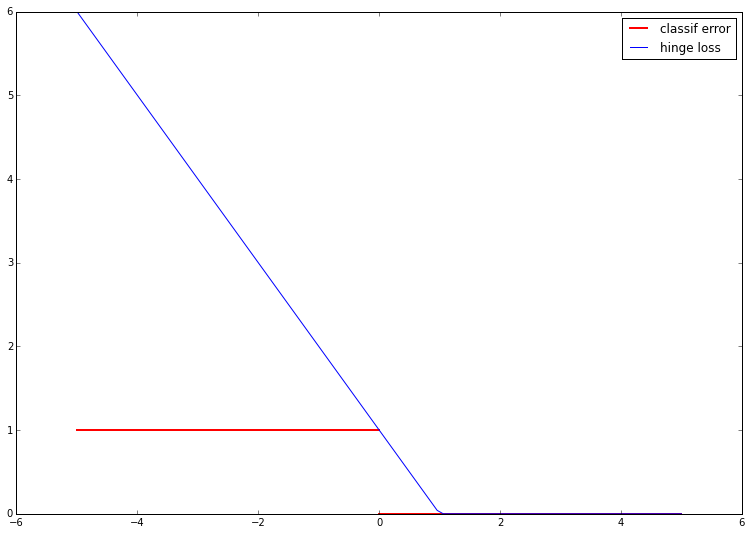

In [125]:
plt.figure(figsize=(13, 9))
x = np.linspace(-5, 5, 100)
x_m = np.linspace(-5, 0, 5)
x_p = np.linspace(0, 5, 5)

hinge = [max(0, 1-i) for i in x]

plt.plot(x_m, np.ones(5), 'r', lw=2)
plt.plot(x_p, np.zeros(5), 'r', lw=2, label='classif error')
plt.plot(x, hinge, label='hinge loss')
plt.legend(loc='best')

### Données pour les questions suivantes

In [126]:
# Download the data (if not already on disk); load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                              color=True, funneled=False, slice_=None)  
# data_home='.'

# introspect the images arrays to find the shapes (for plotting)
images = lfw_people.images / 255.
n_samples, h, w, n_colors = images.shape

# the label to predict is the id of the person
target_names = lfw_people.target_names.tolist()


In [127]:
# Pick a pair to classify such as
names = ['Tony Blair', 'Colin Powell']
#names = ['Donald Rumsfeld', 'Colin Powell']

idx0 = (lfw_people.target == target_names.index(names[0]))
idx1 = (lfw_people.target == target_names.index(names[1]))
images = np.r_[images[idx0], images[idx1]]
n_samples = images.shape[0]
y = np.r_[np.zeros(np.sum(idx0)), np.ones(np.sum(idx1))].astype(np.int)

In [128]:
# Extract features

# features using only illuminations
X = (np.mean(images, axis=3)).reshape(n_samples, -1)

# # or compute features using colors (3 times more features)
# X = images.copy().reshape(n_samples, -1)

# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

In [129]:
# Split data into a half training and half test set
#X_train, X_test, y_train, y_test, images_train, images_test = \
#    train_test_split(X, y, images, test_size=0.5, random_state=0)
#X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.5, random_state=0)

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:X.shape[0]/2], indices[X.shape[0]/2:]
X_train, X_test = X[train_idx,:], X[test_idx,:]
y_train, y_test = y[train_idx], y[test_idx]
images_train, images_test = images[train_idx,:,:,:], images[test_idx,:,:,:]


In [130]:
def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [131]:
def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

#### Question 5

In [132]:
# valeurs de C qui seront testées :
C_values = np.logspace(-5, 5, 30)


def C_testing(X_train, X_test, y_train, y_test, C_values, kernel='linear'):
    """
    Test des valeurs de C données dans C_values
    """
    scores = []

    for c in C_values:
    
        clf = SVC(kernel=kernel, C=c)
        clf = clf.fit(X_train, y_train)
    
        scores.append(clf.score(X_test, y_test))
    
        print "%5.3e, %5.3f"%(c, scores[-1])
        
    return np.asarray(scores)

In [133]:
scores_linear = C_testing(X_train, X_test, y_train, y_test, C_values)

1.000e-05, 0.653
2.212e-05, 0.695
4.894e-05, 0.821
1.083e-04, 0.905
2.395e-04, 0.937
5.298e-04, 0.942
1.172e-03, 0.916
2.593e-03, 0.916
5.736e-03, 0.916
1.269e-02, 0.916
2.807e-02, 0.916
6.210e-02, 0.916
1.374e-01, 0.916
3.039e-01, 0.916
6.723e-01, 0.916
1.487e+00, 0.916
3.290e+00, 0.916
7.279e+00, 0.916
1.610e+01, 0.916
3.562e+01, 0.916
7.880e+01, 0.916
1.743e+02, 0.916
3.857e+02, 0.916
8.532e+02, 0.916
1.887e+03, 0.916
4.175e+03, 0.916
9.237e+03, 0.916
2.043e+04, 0.916
4.520e+04, 0.916
1.000e+05, 0.916


In [134]:
def C_testing_plot(scores, label=None):
    sorted_index = np.argsort(scores)

    print "score max : %6.4f -- best C = %5.3e"%(max(scores), C_values[sorted_index[-1]])

    plt.figure(figsize=(13,9))
    plt.semilogx(C_values, scores, label=label)
    plt.xlabel('C')
    plt.ylabel('accuracy score')
    
    if label != None:
        plt.legend(loc='best')

score max : 0.9421 -- best C = 5.298e-04


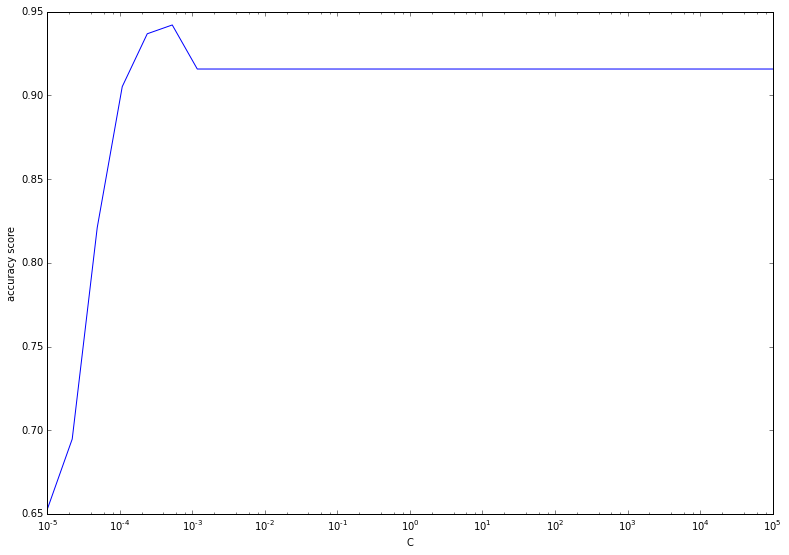

In [136]:
C_testing_plot(scores_linear)

Sur cette figure, on voit l'influence du paramètre C, on observe qu'il existe une valeur optimale de C qui donne le meilleur score pour le modèle. Par ailleurs, cette valeur diffère légèrement d'une exécution à l'autre du programme, à cause de la séparation aléatoire entre données d'entrainement et données de test.

#### Question 6

In [22]:
# fonction pour ajouter n=ncols colonnes de bruits dans un array :
def add_noise(array, ncols=3):
    a = np.random.rand(len(array),ncols)*4. -2.  # valeurs entre -2 and 2
    array = np.append(array, a, axis=1)
    return array

In [23]:
# Pour la meilleur valeur de C,
# On va tester le score de la SVM en ajoutant des colunnes de bruits.
# On garde C=2.4e-4 qui est bonne valeur pour le paramètre de régularisation, d'après les résultats précédents.

N_noisy_max = 30 # number of iterations
N_noisy_step = 500 # number of random columns added at each step

X_train_noisy = X_train
X_test_noisy = X_test


scores = [] # scores
n_cols = [] # number of random columns
for i in range(N_noisy_max):
    
    X_train_noisy = add_noise(X_train_noisy, ncols=N_noisy_step)
    X_test_noisy = add_noise(X_test_noisy, ncols=N_noisy_step)
    
    clf = SVC(kernel='linear', C=2.4e-4)
    clf = clf.fit(X_train_noisy, y_train)

    y_pred = clf.predict(X_test_noisy)
    
    scores.append(clf.score(X_test_noisy, y_test))
    
    if i==0:
        n_cols = [0]
    else:
        n_cols.append(n_cols[-1] + N_noisy_step)
    
    
    print "%5.1f, %5.3f"%(n_cols[-1], scores[-1])

  0.0, 0.905
500.0, 0.884
1000.0, 0.900
1500.0, 0.895
2000.0, 0.905
2500.0, 0.895
3000.0, 0.884
3500.0, 0.889
4000.0, 0.879
4500.0, 0.874
5000.0, 0.874
5500.0, 0.868
6000.0, 0.868
6500.0, 0.858
7000.0, 0.858
7500.0, 0.858
8000.0, 0.853
8500.0, 0.847
9000.0, 0.842
9500.0, 0.853
10000.0, 0.847
10500.0, 0.853
11000.0, 0.853
11500.0, 0.842
12000.0, 0.842
12500.0, 0.832
13000.0, 0.842
13500.0, 0.837
14000.0, 0.842
14500.0, 0.842


(30, 30)


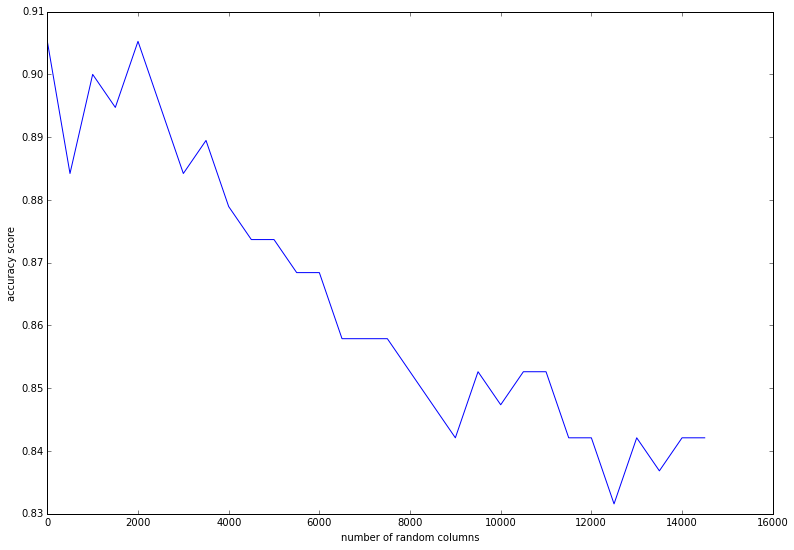

In [24]:
print(len(scores), len(n_cols))

plt.figure(figsize=(13,9))
plt.plot(n_cols, scores)
plt.xlabel("number of random columns")
plt.ylabel('accuracy score')

Il faut ajouter un grand nombre de variables random pour voir une diminution nette de la performance de l'algorithme. Ou bien augmenter l'amplitude de la variable aléatoire (avec des valeurs aléatoires entre -2 et 2, le résultat est plus nette que si les valeurs sont entre -1 et 1, à nombre égal de colonnes ajoutées.

#### Question 7

Comme l'algorithme de SVM repose sur des calculs de distance entre un hyperplan et les points de données, si les variables ne sont pas réduites, on risque de donner trop d'importances aux variables dont les valeurs sont grandes par rapport aux autres. Le fait de centrer les données, permet de réduire la valeur du biais $\omega_0$. 

#### Question 8

In [77]:
scores_rbf = C_testing(X_train, X_test, y_train, y_test, C_values, kernel='rbf')

1.000e-05, 0.674
2.212e-05, 0.674
4.894e-05, 0.674
1.083e-04, 0.674
2.395e-04, 0.674
5.298e-04, 0.674
1.172e-03, 0.674
2.593e-03, 0.674
5.736e-03, 0.674
1.269e-02, 0.674
2.807e-02, 0.674
6.210e-02, 0.674
1.374e-01, 0.674
3.039e-01, 0.695
6.723e-01, 0.779
1.487e+00, 0.837
3.290e+00, 0.853
7.279e+00, 0.853
1.610e+01, 0.853
3.562e+01, 0.853
7.880e+01, 0.853
1.743e+02, 0.853
3.857e+02, 0.853
8.532e+02, 0.853
1.887e+03, 0.853
4.175e+03, 0.853
9.237e+03, 0.853
2.043e+04, 0.853
4.520e+04, 0.853
1.000e+05, 0.853


score max : 0.8526 -- best C = 1.000e+05


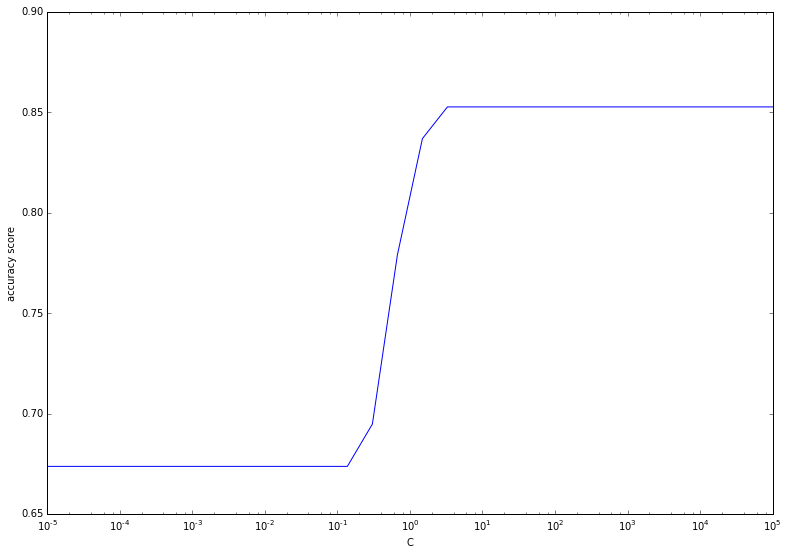

In [78]:
C_testing_plot(scores_rbf)

Un kernel RBF, donne des résultats moins bons que le kernel linéaire.

On va tester l'influence d'une PCA sur la performance d'une SVM à noyau RBF.
On va d'abord déterminer le nombre de composantes principales à sélectionner par PCA pour conserver 95% de la variance du jeux de données d'entrainement.

In [65]:
pca_full = RandomizedPCA(whiten=True)
pca_full.fit(X_train)

RandomizedPCA(copy=True, iterated_power=3, n_components=None,
       random_state=None, whiten=True)

threshold :  0.950016947839 ==> number of components :  99


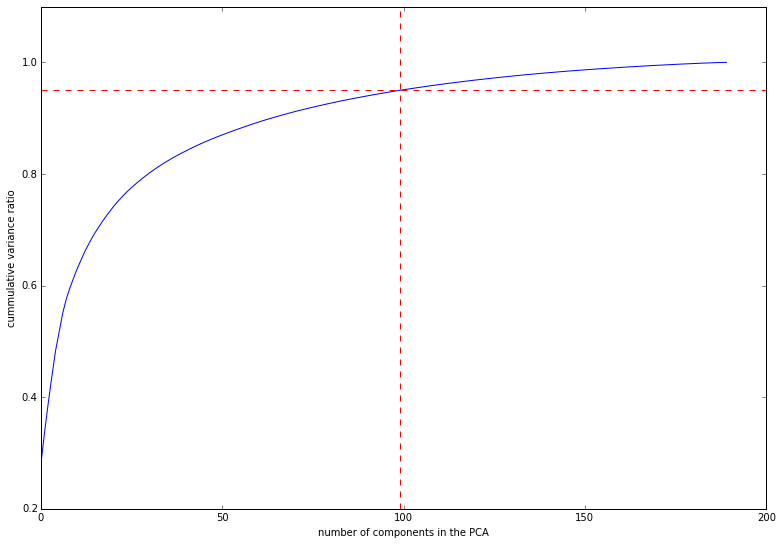

In [66]:
# somme cumulative de la variance des composantes principales
expvar_cumsum = pca_full.explained_variance_ratio_.cumsum()

threshold = expvar_cumsum[expvar_cumsum >= 0.95][0] # first value >= 0.95
n_var = np.argwhere(expvar_cumsum == threshold)[0][0]


print 'threshold : ', threshold, '==> number of components : ', n_var

plt.figure(figsize=(13,9))
plt.ylabel('cummulative variance ratio')
plt.xlabel('number of components in the PCA')
plt.plot(range(len(expvar_cumsum)), expvar_cumsum)
plt.axhline(threshold, c='r', ls='--')
plt.axvline(n_var, c='r', ls='--')

Avec 99 composantes principales, on capture 95% de la variance du jeux de données. On va donc réduire le nombre de features à 64 avec une PCA.

In [67]:
# On applique la PCA avec le nombre de composantes spécifiés plus-haut :
pca = RandomizedPCA(n_components=n_var, whiten=True)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print np.shape(X_train), np.shape(X_train_pca)

(190, 10000) (190, 99)


In [79]:
C_values = np.logspace(-5, 5, 30)

# On teste l'impacte du paramètre C sur les donées modifiées par PCA :
scores_rbf_pca = C_testing(X_train_pca, X_test_pca, y_train, y_test, C_values, kernel='rbf')

1.000e-05, 0.674
2.212e-05, 0.674
4.894e-05, 0.674
1.083e-04, 0.674
2.395e-04, 0.674
5.298e-04, 0.674
1.172e-03, 0.674
2.593e-03, 0.674
5.736e-03, 0.674
1.269e-02, 0.674
2.807e-02, 0.674
6.210e-02, 0.674
1.374e-01, 0.674
3.039e-01, 0.674
6.723e-01, 0.811
1.487e+00, 0.905
3.290e+00, 0.895
7.279e+00, 0.895
1.610e+01, 0.895
3.562e+01, 0.895
7.880e+01, 0.895
1.743e+02, 0.895
3.857e+02, 0.895
8.532e+02, 0.895
1.887e+03, 0.895
4.175e+03, 0.895
9.237e+03, 0.895
2.043e+04, 0.895
4.520e+04, 0.895
1.000e+05, 0.895


score max : 0.9053 -- best C = 1.487e+00


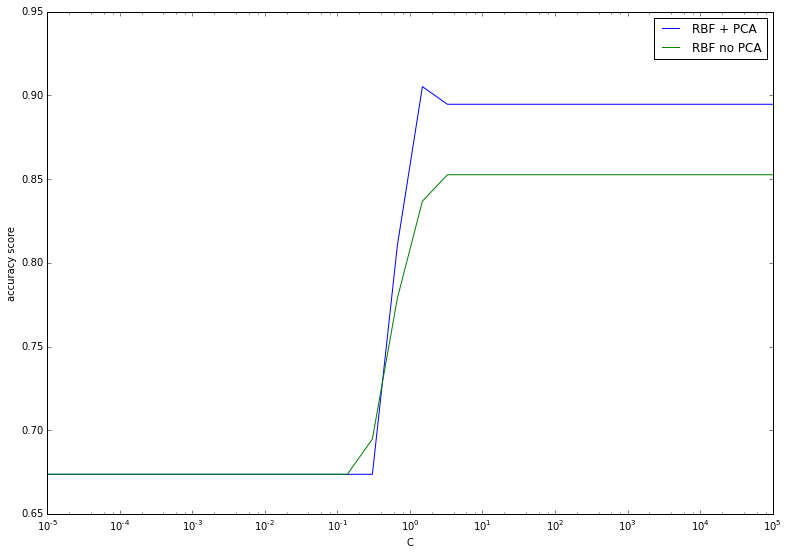

In [80]:
C_testing_plot(scores_rbf_pca, label='RBF + PCA')
plt.plot(C_values, scores_rbf, label='RBF no PCA')
plt.legend(loc='best')

Avec la PCA sur 64 composantes principales on améliore les résultats de la SVM avec le kernel RBF : on passe d'un score de 85% à 91% environ. Et la valeur critique pour l'hyper-paramètre C reste similaire avec ou sans PCA. 

In [81]:
# Même test avec un kernel linéaire :
scores_pca = C_testing(X_train_pca, X_test_pca, y_train, y_test, C_values, kernel='linear')

1.000e-05, 0.674
2.212e-05, 0.674
4.894e-05, 0.674
1.083e-04, 0.674
2.395e-04, 0.674
5.298e-04, 0.674
1.172e-03, 0.674
2.593e-03, 0.700
5.736e-03, 0.905
1.269e-02, 0.895
2.807e-02, 0.889
6.210e-02, 0.874
1.374e-01, 0.879
3.039e-01, 0.879
6.723e-01, 0.879
1.487e+00, 0.879
3.290e+00, 0.879
7.279e+00, 0.879
1.610e+01, 0.879
3.562e+01, 0.879
7.880e+01, 0.879
1.743e+02, 0.879
3.857e+02, 0.879
8.532e+02, 0.879
1.887e+03, 0.879
4.175e+03, 0.879
9.237e+03, 0.879
2.043e+04, 0.879
4.520e+04, 0.879
1.000e+05, 0.879


score max : 0.9053 -- best C = 5.736e-03


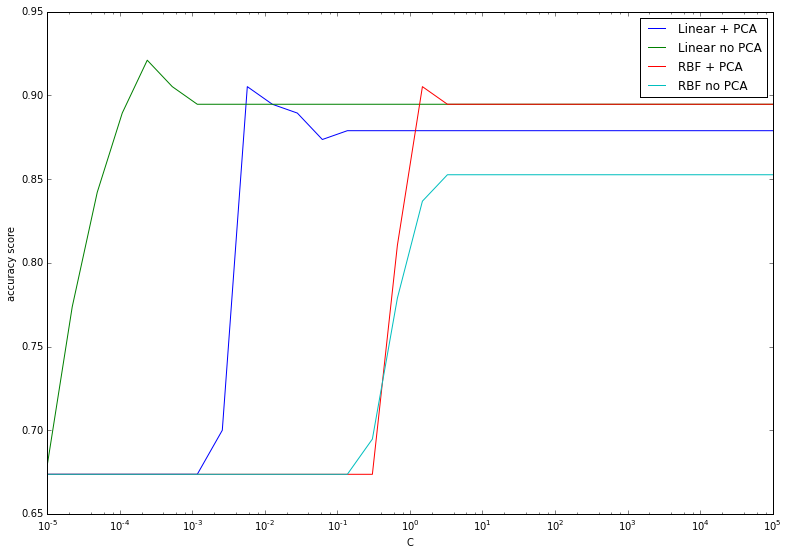

In [84]:
C_testing_plot(scores_pca, label='Linear + PCA')
plt.plot(C_values, scores_linear, label='Linear no PCA')
plt.plot(C_values, scores_rbf_pca, label='RBF + PCA')
plt.plot(C_values, scores_rbf, label='RBF no PCA')
plt.legend(loc='best')

En comparant les différents résultats précédents : le meilleur score est obtenu avec le kernel lineaire sans la PCA capturant 95% de la variance des données. 

#### Question 9

In [117]:
tolerance = np.logspace(-5,0,30)

ws = []
duals = []
intercept = []
for tol in tolerance:
    print tol
    clf = SVC(kernel='linear', C=2.4e-4, tol=tol)
    clf.fit(X_train, y_train)

    ws.append(clf.coef_)
    duals.append(clf.dual_coef_)
    intercept.append(clf.intercept_)
    
ws = np.asarray(ws)

1e-05
1.48735210729e-05
2.21221629107e-05
3.29034456231e-05
4.89390091848e-05
7.27895384398e-05
0.000108263673387
0.000161026202756
0.000239502661999
0.000356224789026
0.000529831690628
0.000788046281567
0.00117210229753
0.0017433288222
0.0025929437974
0.00385662042116
0.00573615251045
0.00853167852417
0.0126896100317
0.0188739182214
0.0280721620394
0.0417531893656
0.0621016941892
0.0923670857187
0.137382379588
0.204335971786
0.303919538231
0.452035365636
0.67233575365
1.0


In [137]:
primal = np.zeros(len(tolerance))
dual = np.zeros(len(tolerance))
saut = np.zeros(len(tolerance))

for i in range(len(tolerance)):
    
    primal[i] = 0.5*norm(ws[i,:])**2 + 2.4e-4*max(0, sum(1 - y_train[i]*(np.dot(ws[i,:], X_train[i,:]) + intercept[i])))
    dual[i] = sum(duals[i][0]) 

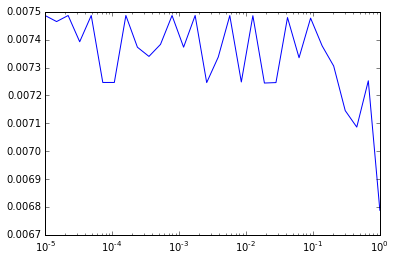

In [138]:
plt.semilogx(tolerance, primal)